## ディープラーニングのモデルを作ってみよう！～回帰モデル

これまでのレッスンと同様、ライブラリのimport、グラフ表示の設定などを行ないます。この他に必要なライブラリについては、使用する際にインポートを行なうことにします。

Kerasについては、tf.keras.◯◯ のように記述して、TensorFlowから呼び出します。

In [1]:
# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Tensorflow
import tensorflow as tf

# データの分割
from sklearn.model_selection import train_test_split

# MSE
from sklearn.metrics import mean_squared_error

# DataFrameで全ての列を表示する設定
pd.options.display.max_columns = None

/Users/MisayoMacBookPro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


回帰モデル用として、Lesson6で用いたプロ野球選手のデータを使用します。

In [2]:
# CSVファイルを読み込む
dataset_base = pd.read_csv("./baseball_salary_preprocessed.csv")
dataset_base.head()

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,打率,試合,打席数,打数,安打,本塁打,打点,盗塁,四球,死球,三振,犠打,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,0.308,143,651,556,171,23,92,13,83,4,113,2,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,0.271,138,629,565,153,14,56,8,32,1,107,30,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,0.290,143,679,565,164,8,60,35,89,15,120,6,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,0.265,116,405,344,91,27,78,0,50,8,111,0,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,0.292,100,288,243,71,9,48,2,40,1,56,0,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


Lesson6と同様、予測に使う列を抜き出します。すべての列を使っても問題ありませんが、ここではLesson6のモデルの性能と比較するために条件を揃えています。

In [4]:
# 列の抜き出し
dataset = dataset_base[['推定年俸', '打点', '年数', '打率', '本塁打', '球団勝率']]

# 列名をリネームする
dataset = dataset.rename(columns={'推定年俸': 'salary', '打点': 'points', '年数': 'years_exp', \
    '打率': 'batting', '本塁打': 'homerun', '球団勝率': 'team_win'})

dataset.head()

,salary,points,years_exp,batting,homerun,team_win
0,21000,92,11,0.308,23,0.633
1,19000,56,7,0.271,14,0.633
2,14000,60,5,0.290,8,0.633
3,11500,78,7,0.265,27,0.633
4,11000,48,20,0.292,9,0.633


In [13]:
print(dataset.info())

print(dataset.describe())

print("len(dataset): ",len(dataset))

print("dataset.shape: ",dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   salary     241 non-null    int64  
 1   points     241 non-null    int64  
 2   years_exp  241 non-null    int64  
 3   batting    241 non-null    float64
 4   homerun    241 non-null    int64  
 5   team_win   241 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 11.4 KB
None
             salary      points   years_exp     batting     homerun  \
count    241.000000  241.000000  241.000000  241.000000  241.000000   
mean    6843.692946   24.713693    8.248963    0.237324    5.651452   
std     9613.580198   26.202357    4.705964    0.066306    8.150338   
min      450.000000    0.000000    2.000000    0.000000    0.000000   
25%     1300.000000    3.000000    4.000000    0.205000    0.000000   
50%     2500.000000   13.000000    7.000000    0.243000    2.000000   
75%     7300.000000   4

データの前処理
説明変数の値の範囲が大きく異なる場合、正規化を行なうことが一般的です。ここでは MinMaxScaler を用いて正規化を行ないます。

In [14]:
# MinMaxScalerで正規化を実施
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
dataset_std = sc.fit_transform(dataset)
dataset_std.shape

(241, 6)

目的変数は0列目、説明変数は1列目以降となります。

In [15]:
# 目的変数Y:dataset_stdの0列
Y = dataset_std[:, 0]

# 特徴量X:datastd_stdの1列目以降
X = dataset_std[:, 1:]
print("Y:", Y.shape)
print("X:", X.shape)

Y: (241,)
X: (241, 5)


データの用意ができたら分割を行ないます。

In [16]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [18]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (117,) , X_train= (117, 5)
Y_valid= (51,) , X_valid= (51, 5)
Y_test= (73,) , X_test= (73, 5)


<モデルの構築>

Kerasでは 層 を重ねてモデルを構築します。今回はシンプルに以下の層で構成されたモデルを構築します。

入力層 x 1層（説明変数を受け取る）
隠れ層 x 1層
出力層 x 1層（出力値が年俸となる）

これをKerasで記述すると以下のようになります。

In [19]:
import tensorflow as tf

# モデルの初期化
model = tf.keras.Sequential([
    # 入力層
    tf.keras.Input(shape=(5,)),
    tf.keras.layers.Dense(8, activation='relu'),
    # 隠れ層
    tf.keras.layers.Dense(8, activation='relu'),
    # 出力層
    tf.keras.layers.Dense(1)
])

# モデルの構築
model.compile(optimizer="rmsprop", loss='mse', metrics=['mae'])

Kerasで層を重ねていくモデルを作る場合、tf.keras.Sequential クラスを使用します。このクラスのコンストラクタに、モデルを構成するレイヤーのリストを渡すことで、層が順番に接続されたモデルを定義できます。

#入力層
最初の要素として tf.keras.Input(shape=(5,)) を指定しています。これはモデルが受け取る入力データの形状を定義するものです。Kerasでは1次元だけでなく、2次元、3次元以上のデータの入力も可能です。今回は説明変数の列数が5なので、shape=(5,) と指定しています。

その次に続く tf.keras.layers.Dense(8, activation='relu') が最初の「層」となります。この層は「前の層（この場合は入力）からのすべての入力を次の層に出力する」ものです。このような層を 全結合層 と呼びます。全結合層はKerasでは Dense というクラスで表します。全結合層はもっとも単純な層の1つです。その他にも学習するデータの種類に応じて、いくつかの層のクラスが用意されています。

- Dense の第一引数の「8」は出力する形状です。ここでは8としていますが、任意の数を指定できます。
- 活性化関数は activation 引数で指定します。今回は relu を指定しています。
- この最初の Dense 層の入力形状は、直前の tf.keras.Input で定義された形状から自動的に設定されます。

#隠れ層
隠れ層もほぼ同様です。tf.keras.layers.Dense を使用し、出力の形状と活性化関数を指定します。この層の入力形状は、前の層（この場合は最初の Dense 層）の出力形状から自動的に設定されます。

#出力層
今回の回帰モデルでは、目的変数が1つ（年俸）で、その1つの数値を予測するだけなので、出力層の形状は「1」です（tf.keras.layers.Dense(1)）。また、出力層の結果がそのまま予測値となるため、活性化関数は指定しません（0～1の範囲の値を予測するような場合は「sigmoid」関数を出力層の活性化関数に指定する場合があります）。

#モデルの構築
最後に compile でモデルを構築します。オプティマイザは optimizer で指定します。ここでは rmsprop を指定しています。オプティマイザには、この他にも SGD や Adam などがあります。

目的関数は loss で指定します。ここでは mse（平均2乗誤差）を指定しています。また、学習時の性能を評価する関数として metrics に mae を指定しています。MAE（Mean Absolute Error、平均絶対誤差）は予測値と正解との誤差の絶対値を表します。

モデルの構築が終わったら、構造を確認してみましょう。

In [20]:
# モデルの構造を表示
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

入力層のパラメータの数は次のように計算できます。入力と出力の間の結合係数（重み）が入力サイズ5と出力サイズ8をかけた40個、出力の1つ1つにReLU活性化関数の立ち上がりの位置（しきい値）を表すパラメータがあり、出力の個数分で8個．合計で48個になります。

<学習の実施>

Kerasの学習は、scikit-learnと同じく fit() で行ないます。学習には少々時間がかかります。このような場合セルの先頭に %%time マジックコメントを記載しておくことで、かかった時間を計測できます。

fit() には、第1引数に説明変数、第2引数に目的変数を指定します。エポック数（epochs）、バッチサイズ（batch_size）は適当に設定しています。 verbose=True は学習中のログを出力する設定です。 validation_data で検証データを指定します。なお、実行結果は、環境やタイミングによって変わります。

In [21]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=48, verbose=True,
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1028 - mae: 0.2361 - val_loss: 0.1088 - val_mae: 0.2083
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0844 - mae: 0.2016 - val_loss: 0.0963 - val_mae: 0.1820
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0738 - mae: 0.1783 - val_loss: 0.0879 - val_mae: 0.1636
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0664 - mae: 0.1620 - val_loss: 0.0819 - val_mae: 0.1498
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0607 - mae: 0.1487 - val_loss: 0.0762 - val_mae: 0.1371
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0556 - mae: 0.1364 - val_loss: 0.0718 - val_mae: 0.1269
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0513 - mae: 0.1283 - val_loss: 0.0675 - val_mae: 0.1206
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0473 - mae: 0.1210 - val_loss: 0.0637 - val_mae: 0.1184
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.044

loss は学習データ(X/Y_train)に対するMSE、 mae は学習データに対するMAEを表します。同様に val_loss は検証データ(X/Y_valid)に対するMSE、 val_mae は検証データに対するMAEです。これらの学習過程の情報は fit() の戻り値として返されます。上記の場合、log変数で受け取っています。

* mse（平均2乗誤差）:目的関数（ここではlossと呼ばれている）の結果を評価
* MAE（Mean Absolute Error、平均絶対誤差）:学習時の性能を評価

<学習結果の確認>
logで受け取ったMSEをグラフで確認してみましょう。

Text(0, 0.5, 'MSE')

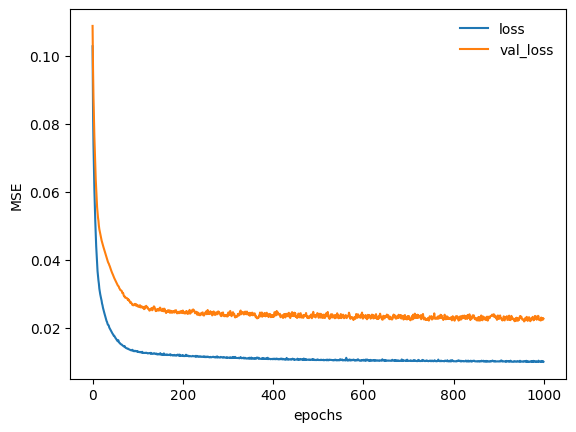

In [22]:
# MSEをグラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("MSE")

loss(学習データのMSE)が右肩下がりでどこまでも下がるのに対して、val_loss(検証データのMSE)は途中から下がらずやや右肩上がりになっていることがわかります。これはエポック数が多すぎて 過学習 に陥っていることを表します。過学習になる直前がエポック数として最適です。

<keras.callbacks.EarlyStopping>
Kerasでは、過学習になる直前で停止させる EarlyStopping という機能が用意されています。モデルを fit() させる際 callbacks に keras.callbacks.EarlyStopping を指定することで、過学習になる直前のエポック数で学習を停止させることができます。

In [26]:
# モデルを作り直す
model = tf.keras.Sequential([
    # 入力層
    tf.keras.Input(shape=(5,)),
    tf.keras.layers.Dense(8, activation='relu'),
    # 隠れ層
    tf.keras.layers.Dense(8, activation='relu'),
    # 出力層
    tf.keras.layers.Dense(1)
])
model.compile(optimizer="rmsprop", loss='mse', metrics=['mae'])

# EarlyStoppingを入れて学習を実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=48, verbose=False,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            min_delta=0, patience=100,
                                                            verbose=1)],
                validation_data=(X_valid, Y_valid))

Epoch 276: early stopping


今回は276回が最適なエポック数であるようです（実行結果は環境やタイミングによって異なります）。改めてグラフで確認してみましょう。

Text(0, 0.5, 'MSE')

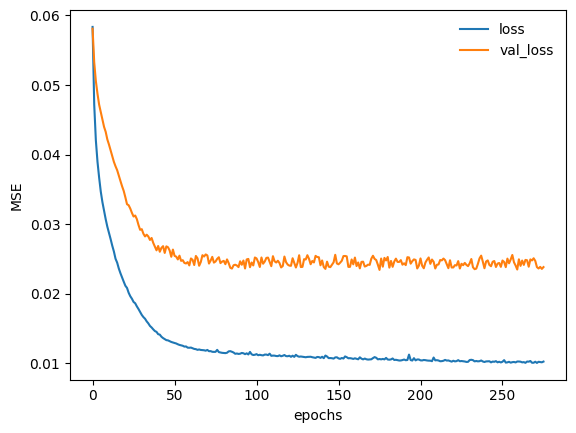

In [27]:
# 改めてMSEをグラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("MSE")

<テストデータによる評価>
最後にテストデータによる汎化性能を評価しましょう。予測が predict() であるのもscikit-learnと同様です。Kerasの関数名はscikit-learnに合わせてつくられています。

In [28]:
# テストデータによる予測。予測はpredictを使う
Y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


このままだと、正規化した予測値であるため、年俸に復元します。復元にはMinMaxScalerの inverse_transform を使用します。

In [29]:
# 正規化した値を元に戻すにはinverse_transformを使う
# 行列の形はdatasetと一致している必要があるため、XとYを結合させる
Y_test_ = sc.inverse_transform(np.hstack([Y_test.reshape(len(Y_test), 1), X_test]))[:, 0]
Y_pred_ = sc.inverse_transform(np.hstack([Y_pred.reshape(len(Y_pred), 1), X_test]))[:, 0]

復元が終わったら平均2乗誤差を確認します。

In [30]:
# MSE(平均2乗誤差)を算出
mse = mean_squared_error(Y_test_, Y_pred_)
print('MSE(Keras回帰モデル):', mse)

MSE(Keras回帰モデル): 34171395.227376565


数値は環境によって異なりますが、Lesson6でパラメータをチューニングしたランダムフォレストの結果が「53252054.13427011」でしたので、それよりも性能が良くなりました。

最後に正解と予測値で散布図を作成してみましょう。右肩上がりの傾向があり、ある程度予測できていそうです。

Text(0, 0.5, 'prediction')

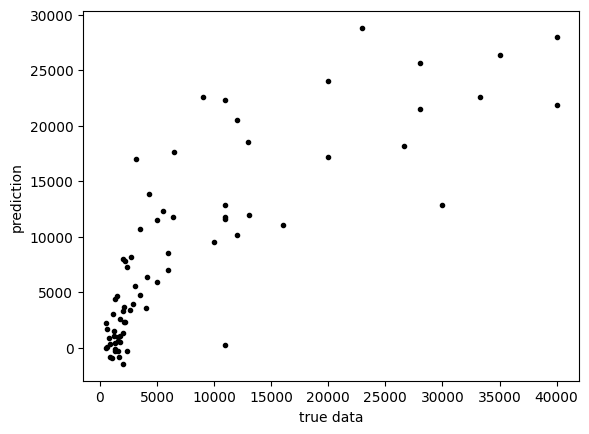

In [31]:
# 予測値と正解の散布図の表示
plt.plot(Y_test_, Y_pred_, 'k.')
plt.xlabel("true data")
plt.ylabel("prediction")

説明変数を増やしたり、モデルの層やパラメータを変えることで、より性能の良いモデルを作成できる可能性があります。いろいろと試してみましょう。